# PyTorch （ml_15~）

## 多値分類（７章）

In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [45]:
# torch関連

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [46]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=4)

### データ読み込み

In [47]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


２入力３出力とする

In [48]:
# 入力データ絞り込み

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]

# 結果確認
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


In [49]:
# データの分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


In [50]:
# 正解データ値で分割
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

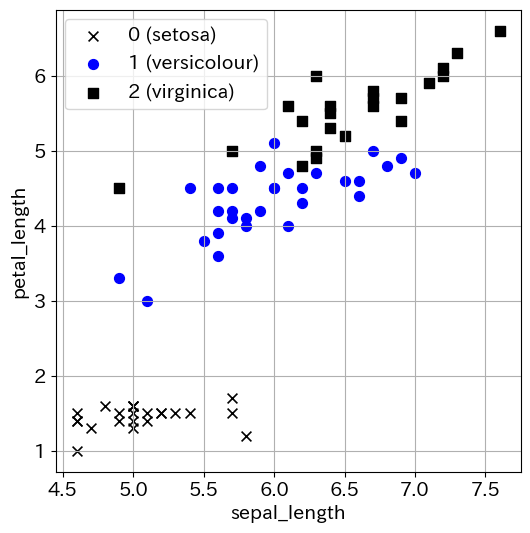

In [51]:
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='s', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()

### モデル定義

In [52]:
n_input = x_train.shape[1]
n_output = len(set(y_train))
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 3


In [53]:

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)

        # 初期値を全部1にする
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1

# インスタンスの生成
net = Net(n_input, n_output)

In [54]:
for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [55]:
print(net)

Net(
  (l1): Linear(in_features=2, out_features=3, bias=True)
)


In [56]:
summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [3]                       --
├─Linear: 1-1                            [3]                       9
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [57]:
# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

In [58]:
# 学習データx_trainと正解値 y_trainのテンソル変換
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証データのテンソル変換
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

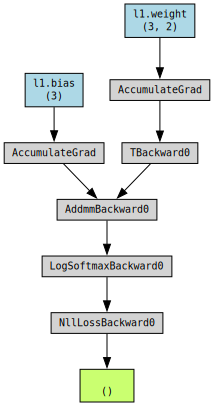

In [59]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 学習

In [60]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [61]:
# 繰り返し計算メインループ
for epoch in range(num_epochs):

    ## 訓練フェーズ

    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 予測ラベル算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    ##予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ((epoch) % 1000 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263, val_acc: 0.26667
Epoch [1000/10000], loss: 0.45458 acc: 0.89333 val_loss: 0.44133, val_acc: 0.92000
Epoch [2000/10000], loss: 0.36869 acc: 0.90667 val_loss: 0.35477, val_acc: 0.94667
Epoch [3000/10000], loss: 0.32137 acc: 0.90667 val_loss: 0.30714, val_acc: 0.94667
Epoch [4000/10000], loss: 0.29052 acc: 0.90667 val_loss: 0.27581, val_acc: 0.96000
Epoch [5000/10000], loss: 0.26879 acc: 0.90667 val_loss: 0.25354, val_acc: 0.96000
Epoch [6000/10000], loss: 0.25269 acc: 0.90667 val_loss: 0.23687, val_acc: 0.96000
Epoch [7000/10000], loss: 0.24030 acc: 0.90667 val_loss: 0.22391, val_acc: 0.96000
Epoch [8000/10000], loss: 0.23046 acc: 0.90667 val_loss: 0.21353, val_acc: 0.96000
Epoch [9000/10000], loss: 0.22247 acc: 0.90667 val_loss: 0.20501, val_acc: 0.96000


### 結果の確認

In [62]:
#損失と精度の確認
print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.09263 精度: 0.26667
最終状態: 損失: 0.20501 精度: 0.96000


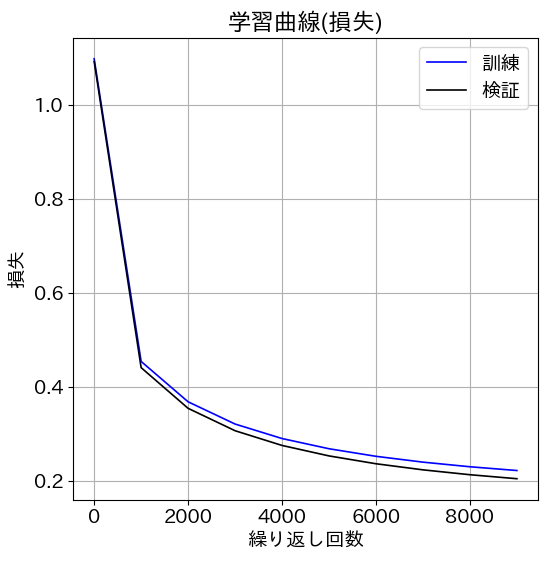

In [64]:
# 学習曲線の表示 (損失)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()

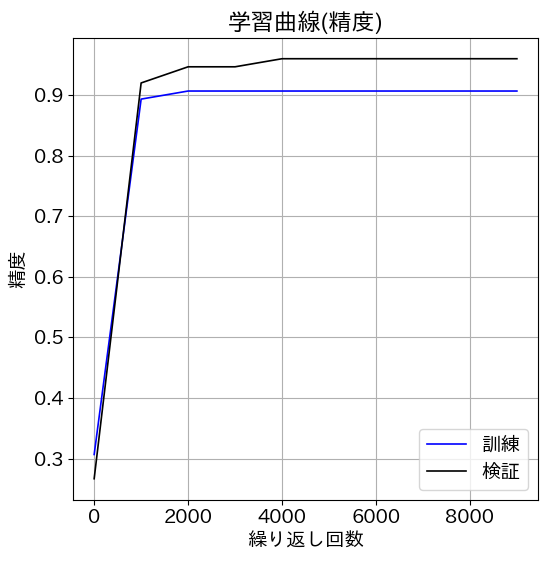

In [65]:
# 学習曲線の表示 (精度)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()

In [73]:
labels

tensor([1, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1,
        2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 2,
        2, 0, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1,
        1, 2, 2])

この結果から、labelsの０番目、２番目、３番目が順に 1, 0, 2 が初めて出てくる添字と分かる。

In [77]:
labels[[0, 2, 3]]

tensor([1, 0, 2])

In [82]:
# 添字に対応する入力を抜き出す
i3 = inputs[[0, 2, 3]]
print(i3.data.numpy())

[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


In [114]:
# 出力値にsoftmax関数をかけた結果を取得
softmax = torch.nn.Softmax(dim=1)
# 出力値
o3 = net(i3)
# softmax関数適用後
k3 = softmax(o3)
# maxになる添字が 1, 0, 2 になることを確認
print(o3.data.numpy())
# softmax関数適用後も同じ（softmax関数が増加関数だから？）
print(k3.data.numpy())

[[ 8.8071 14.1938 12.9986]
 [12.8262  9.8     0.1734]
 [ 6.7954 15.0928 17.1111]]
[[0.0035 0.765  0.2315]
 [0.9537 0.0463 0.    ]
 [0.     0.1173 0.8827]]


In [115]:
# 重み行列
print(net.l1.weight.data)

# バイアス
print(net.l1.bias.data)

tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]])
tensor([ 1.7178,  1.6563, -0.3741])


In [116]:
# x, yの描画領域計算
x_min = x_train[:,0].min()
x_max = x_train[:,0].max()
y_min = x_train[:,1].min()
y_max = x_train[:,1].max()
x_bound = torch.tensor([x_min, x_max])

# 結果確認
print(x_bound)

tensor([4.6000, 7.6000], dtype=torch.float64)


In [117]:
# 決定境界用の１次関数定義
def d_bound(x, i, W, B):
    W1 = W[[2,0,1],:]
    W2 = W - W1
    w = W2[i,:]
    B1 = B[[2,0,1]]
    B2 = B - B1
    b = B2[i]
    v = -1/w[1]*(w[0]*x + b)
    return v

In [118]:
# 決定境界のyの値を計算
W = net.l1.weight.data
B = net.l1.bias.data

y0_bound = d_bound(x_bound, 0, W, B)
y1_bound = d_bound(x_bound, 1, W, B)
y2_bound = d_bound(x_bound, 2, W, B)

# 結果確認
print(y0_bound)
print(y1_bound)
print(y2_bound)

tensor([3.0898, 4.9179], dtype=torch.float64)
tensor([2.2871, 3.7670], dtype=torch.float64)
tensor([3.7981, 5.9337], dtype=torch.float64)


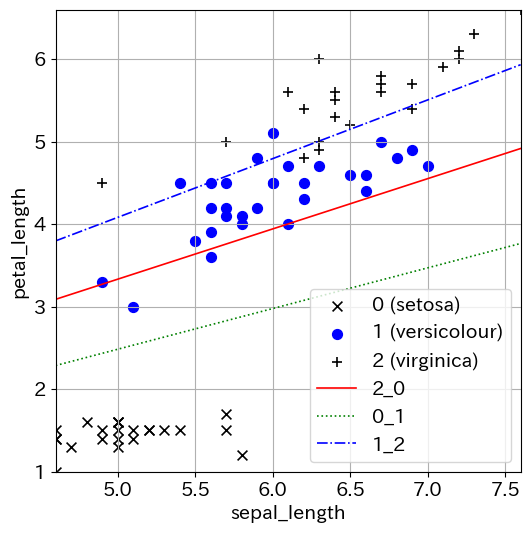

In [119]:
# xとyの範囲を明示的に指定
plt.axis([x_min, x_max, y_min, y_max])

# 散布図
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')

# 決定境界
plt.plot(x_bound, y0_bound, label='2_0')
plt.plot(x_bound, y1_bound, linestyle=':',label='0_1')
plt.plot(x_bound, y2_bound,linestyle='-.',label='1_2')

# 軸ラベルと凡例
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()